In [157]:
import asyncio
import json
from typing import List
from datetime import datetime, timedelta

from grpclib.client import Channel
from cortexadmin_pb import CortexAdminStub, SeriesRequest, QueryRangeRequest, QueryRequest, MatcherRequest
from betterproto.lib.google.protobuf import Empty

default_query_interval = "1m"

async def get_all_users(service: CortexAdminStub) -> List[str]:
  response = await service.all_user_stats(Empty())
  return [r.user_id for r in response.items]

async def list_all_metric(service: CortexAdminStub, cluster_id: str) -> List[str]:
  response = await service.extract_raw_series(MatcherRequest(tenant=cluster_id, match_expr=".+"))
  res = (json.loads(response.data.decode())["data"])
  s = set()
  for r in res["result"]:
    s.add(r["metric"]["__name__"])
  return list(s)

async def metric_query(service: CortexAdminStub, cluster_id: str, metric_name: str, namespace="opni"):
  query = f'sum(rate({metric_name}{{namespace="{namespace}"}}[{default_query_interval}])) by (pod)'
  response = await service.query(QueryRequest(tenants=[cluster_id], query=query))
  response = json.loads(response.data.decode())["data"]
  return response

async def metric_queryrange(service: CortexAdminStub, cluster_id: str, metric_name: str, namespace="opni", end_time : datetime = None, time_delta : timedelta= timedelta(minutes=60), step_minute : int = 1):
  query_interval = "2m"# f"{step_minute}m"
  query = f'sum(rate({metric_name}{{namespace="{namespace}"}}[{query_interval}])) by (pod)'
  if end_time is None:
    end_time = datetime.now()
  start_time = end_time - time_delta
  response = await service.query_range(QueryRangeRequest(tenants=[cluster_id], query=query, start=start_time, end=end_time, step=timedelta(minutes=step_minute)))
  response = json.loads(response.data.decode())["data"]
  return response

In [50]:
channel = Channel(host="localhost", port=11090) # url of opni-internal. can port-forward to localhost:11090
service = CortexAdminStub(channel)

Unclosed connection: Channel('localhost', 11090, ..., path=None)


In [24]:
user_id = (await get_all_users(service))[0]
user_id

'6165ba24-e496-491d-86f2-6eb083f24f0b'

In [102]:
metrics = await list_all_metric(service, user_id)

In [103]:
import matplotlib.pyplot as plt
import numpy as np
def plt_plot(ts_data):
    # Plot the time series data
    plt.plot(ts_data)
    plt.title("Time Series Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()


In [195]:
from scipy.stats import ks_2samp
from collections import defaultdict

threshold = 0.01

def moving_average(data, window_size=2):
    data = np.array(data)

    weights = np.repeat(1.0, window_size) / window_size
    moving_avg = np.convolve(data, weights, 'valid')
    return moving_avg

def ks_anomaly_detection(metric_values: List[float], cut : int = 50):
    # metric_values = moving_average(metric_values)
    l1, l2 = metric_values[:cut], metric_values[cut:]
    ks_stat, p_value = ks_2samp(l1, l2)
    if p_value < threshold:
        return True, p_value
    else:
        return False, p_value

def zscore_anomaly_detection(metric_values: List[float]):
    mean = np.mean(metric_values)
    std_dev = np.std(metric_values)

    # set a threshold value
    threshold = 5

    # identify anomalies using z-score
    anomalies = []
    for x in metric_values:
        z_score = abs((x - mean) / std_dev)
        if z_score > threshold:
            anomalies.append(x)
    return anomalies

import time 

async def run_task(end_time, m_name = None):
    # if m_name is None:
    #     m_name = "container_cpu_usage_seconds_total"
    q1 = await metric_queryrange(service, user_id, m_name,end_time=end_time, time_delta=timedelta(minutes=300),step_minute=1)
    return q1



In [153]:
fixed_ts = datetime.now()
fixed_ts

datetime.datetime(2023, 3, 15, 14, 12, 17, 287129)

In [168]:

qs = []
for m in metrics:
    q1 = await run_task(fixed_ts ,m_name=m)
    qs.append(q1)


In [173]:
def process_task(d, q1 ,m_name, is_debug = False):
    count = 0
    total = 0
    for r in q1["result"]:
        if "pod" not in r["metric"]:
            # print(r)
            continue
        pod = r["metric"]["pod"]
        list0 = r["values"]
        values0 = [float(l[1]) for l in list0]
        try:
            is_anomaly, p_value = ks_anomaly_detection(values0[-60:])
            total += 1
            if is_anomaly:

                z_s = zscore_anomaly_detection(values0)
                z_s_binary = True if len(z_s) > 0 else False
                # if z_s_binary:
                count += 1
                d[pod].append(m_name)
                if is_debug:
                # if True:
                    print(pod)
                    plt_plot(np.array(values0))
                    print(z_s_binary)
                    print("=====================")
        except Exception as e:
            pass
    s2 = time.time()
    return count, total

d = defaultdict(list)
total_count = 0
total = 0
for i,q in enumerate(qs):
    c, t = process_task(d,q, metrics[i])
    total_count += c
    total += t
print(total_count)
print(total)
print(d)

104
3685
defaultdict(<class 'list'>, {'cortex-all-0': ['cortex_querier_blocks_consistency_checks_total', 'cortex_storegateway_client_request_duration_seconds_bucket', 'cortex_bucket_store_series_data_size_fetched_bytes', 'cortex_bucket_store_series_data_size_touched_bytes_count', 'thanos_objstore_bucket_operation_duration_seconds_count', 'cortex_querier_storegateway_refetches_per_query_count', 'container_network_receive_packets_total', 'cortex_distributor_ingestion_rate_samples_per_second', 'cortex_response_message_bytes_bucket', 'go_memstats_mspan_inuse_bytes', 'cortex_bucket_store_series_get_all_duration_seconds_count', 'cortex_bucket_store_series_merge_duration_seconds_bucket', 'go_memstats_heap_objects', 'scrape_duration_seconds', 'cortex_storegateway_client_request_duration_seconds_count', 'cortex_bucket_stores_gate_queries_total', 'cortex_bucket_stores_gate_duration_seconds_count', 'cortex_bucket_store_series_blocks_queried_count', 'cortex_bucket_stores_gate_duration_seconds_buck

process_cpu_seconds_total
opni-prometheus-node-exporter-d4tmr


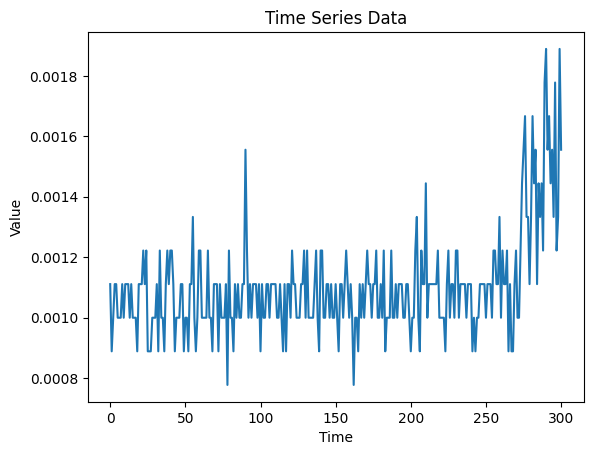

node_scrape_collector_duration_seconds
opni-prometheus-node-exporter-d4tmr


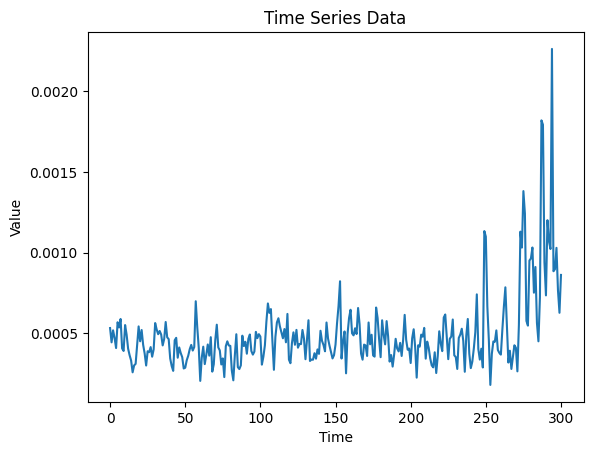

container_cpu_usage_seconds_total
opni-kube-state-metrics-5df8ccf5-mkhfl


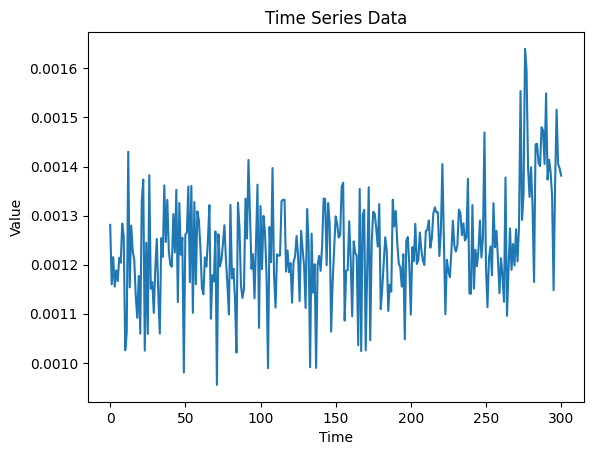

container_cpu_usage_seconds_total
opni-nats-1


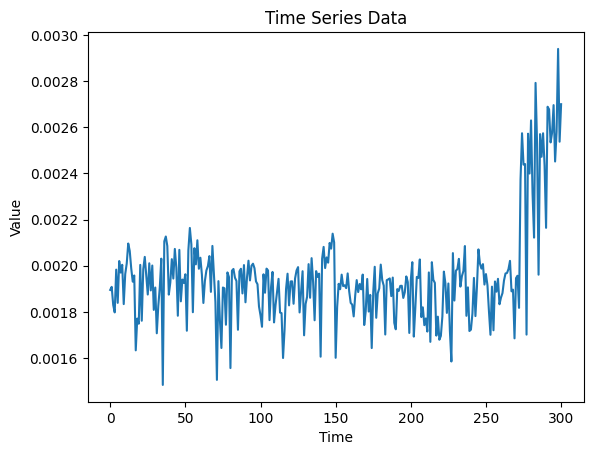

container_cpu_usage_seconds_total
opni-prometheus-node-exporter-d4tmr


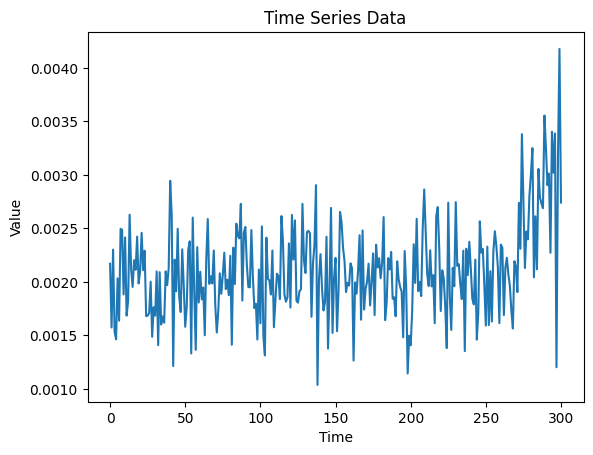

container_cpu_usage_seconds_total
prometheus-opni-prometheus-agent-0


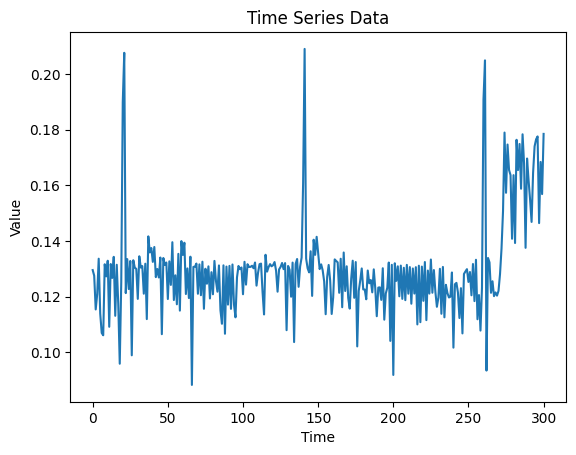

go_gc_duration_seconds_sum
opni-prometheus-node-exporter-d4tmr


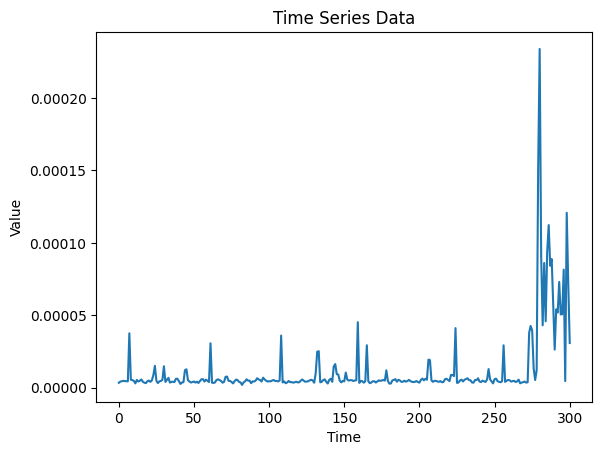

container_network_receive_packets_total
cortex-all-0


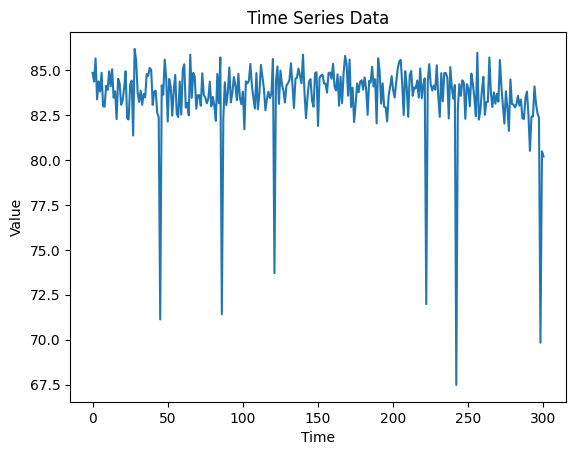

scrape_duration_seconds
cortex-all-0


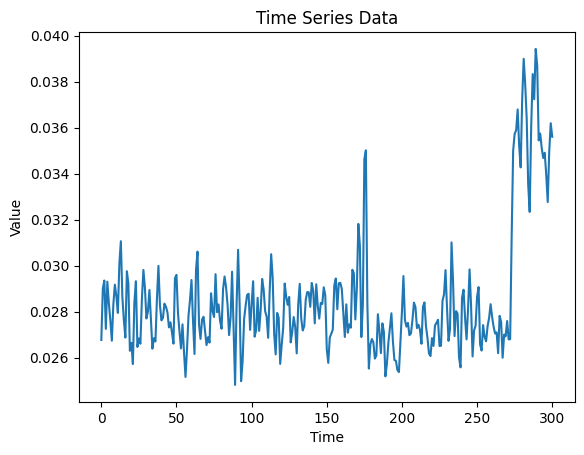

scrape_duration_seconds
opni-kube-state-metrics-5df8ccf5-mkhfl


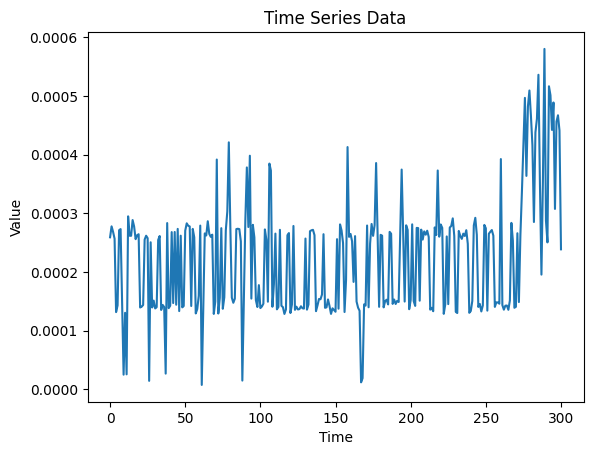

scrape_duration_seconds
opni-prometheus-node-exporter-d4tmr


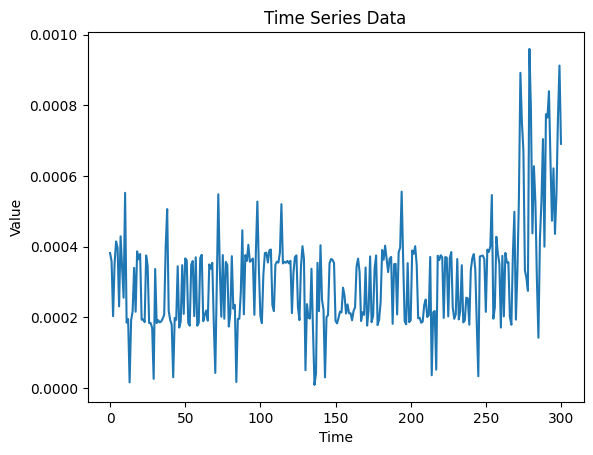

node_schedstat_running_seconds_total
opni-prometheus-node-exporter-d4tmr


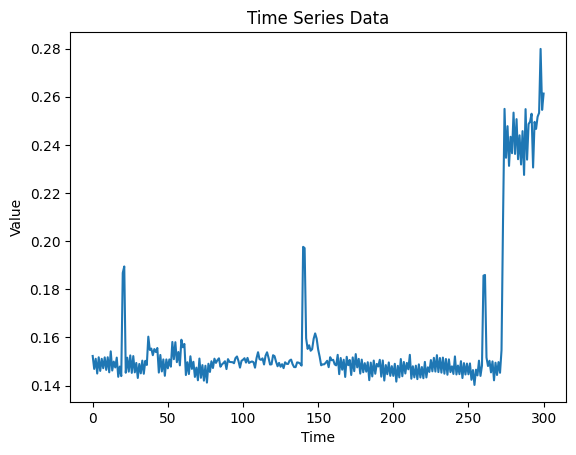

instance:node_load1_per_cpu:ratio
opni-prometheus-node-exporter-d4tmr


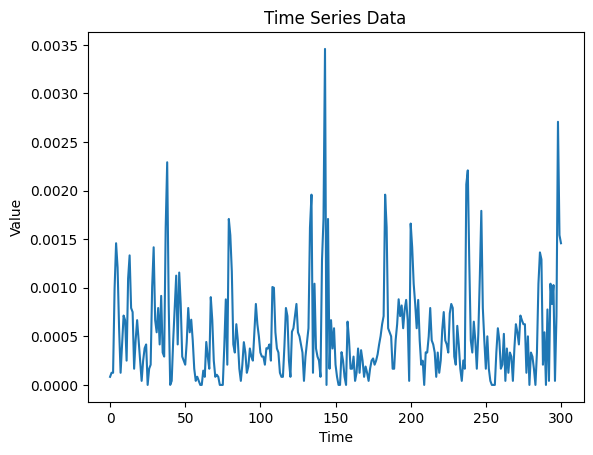

go_memstats_gc_cpu_fraction
opni-prometheus-node-exporter-6zq4r


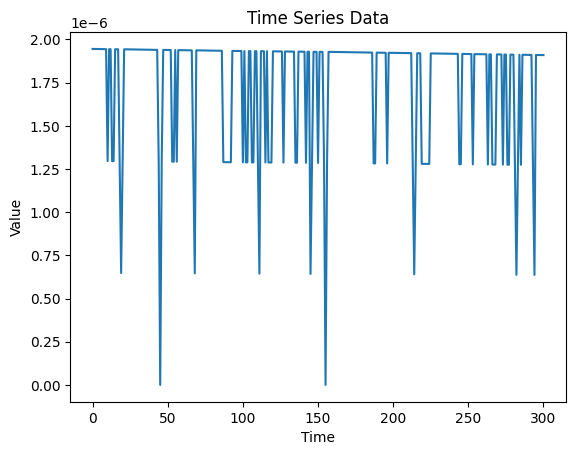

go_memstats_gc_cpu_fraction
opni-prometheus-node-exporter-d4tmr


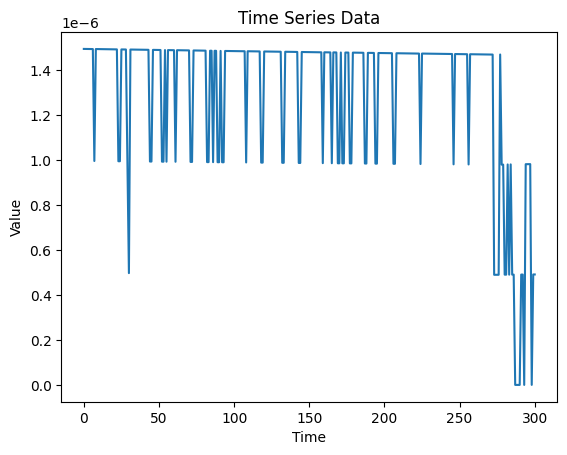

container_network_transmit_packets_total
prometheus-opni-prometheus-agent-0


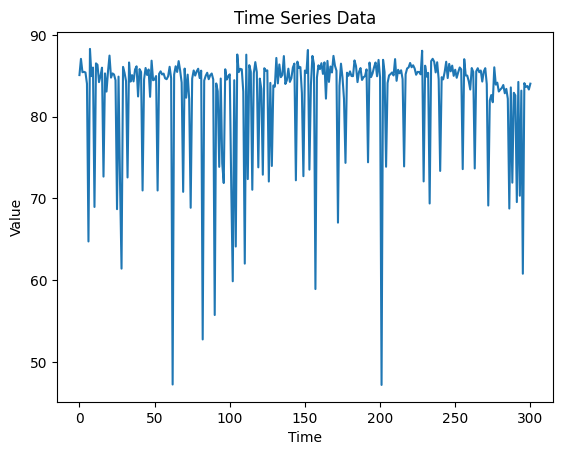

node_cpu_seconds_total
opni-prometheus-node-exporter-d4tmr


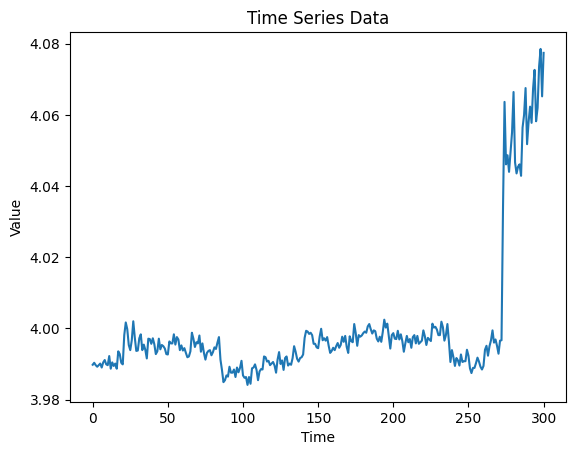

log_messages_total
cortex-all-0


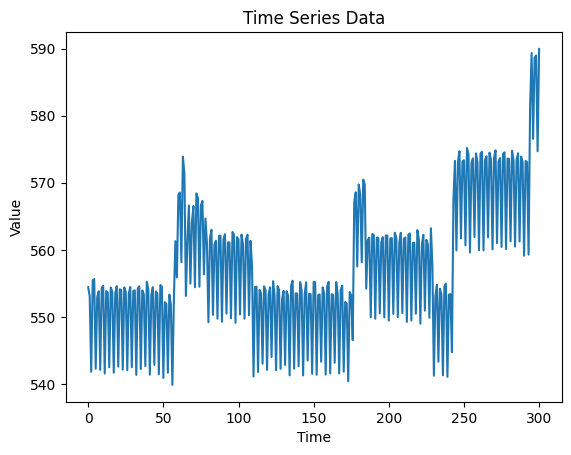

cortex_prometheus_notifications_latency_seconds_sum
cortex-all-0


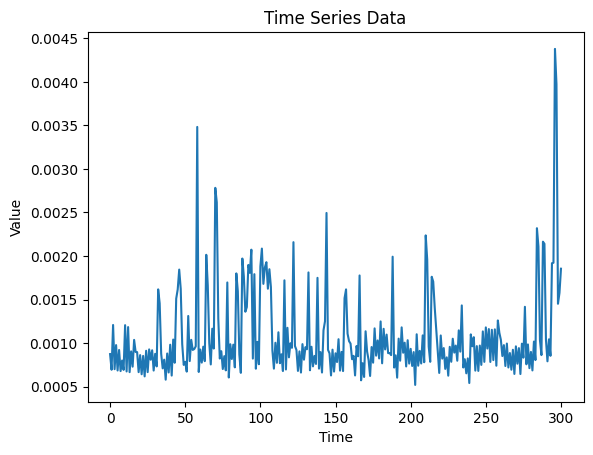

node_schedstat_waiting_seconds_total
opni-prometheus-node-exporter-d4tmr


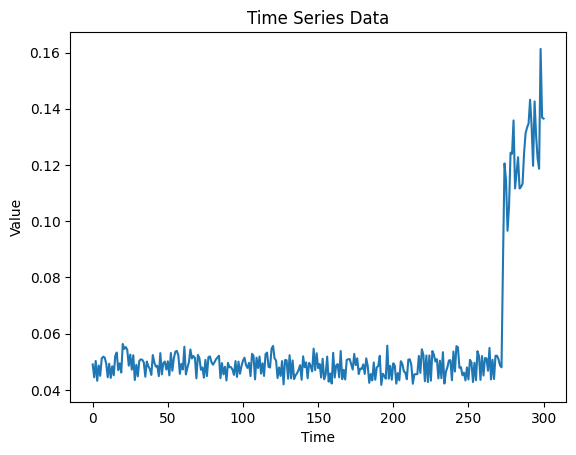

node_schedstat_waiting_seconds_total
opni-prometheus-node-exporter-ljdr6


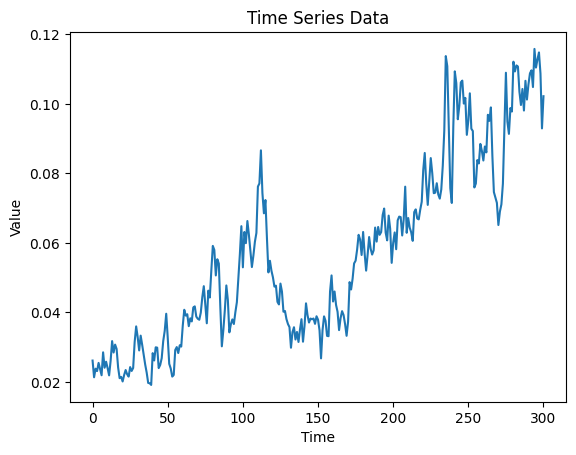

container_cpu_system_seconds_total
prometheus-opni-prometheus-agent-0


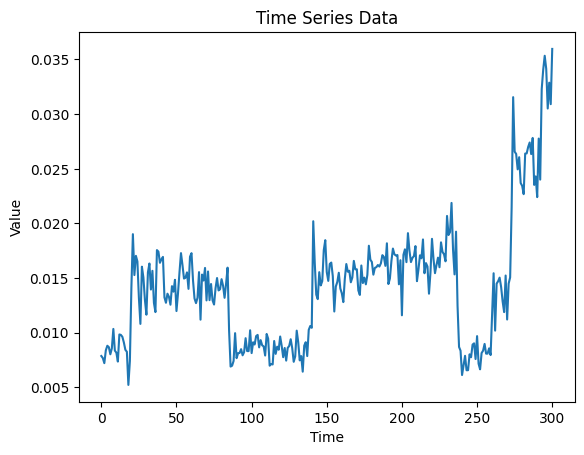

node_pressure_cpu_waiting_seconds_total
opni-prometheus-node-exporter-d4tmr


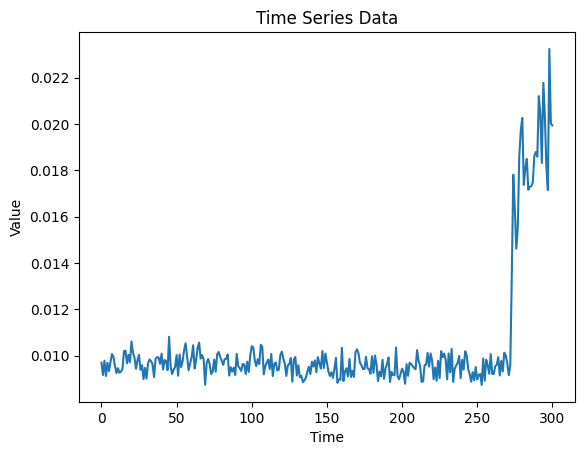

process_memory_map_areas
cortex-all-0


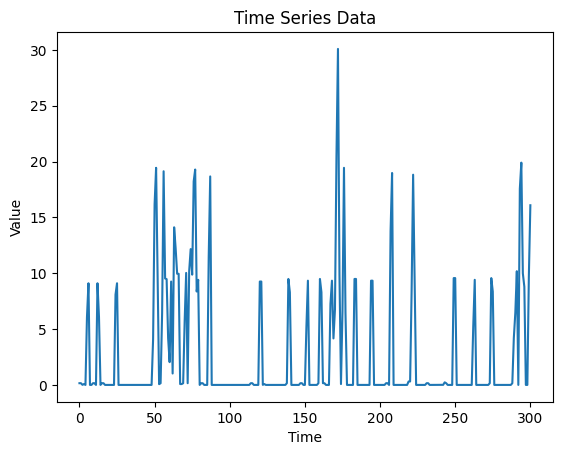

node_netstat_Tcp_PassiveOpens
opni-prometheus-node-exporter-d4tmr


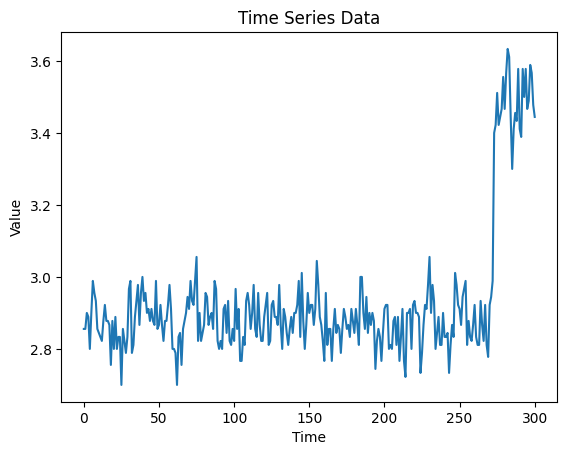

node_softnet_times_squeezed_total
opni-prometheus-node-exporter-d4tmr


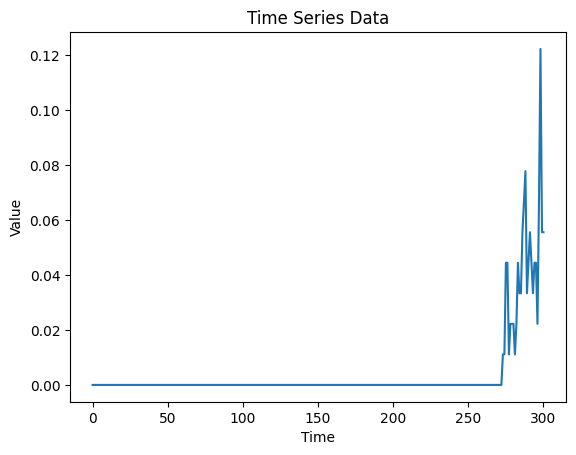

container_cpu_user_seconds_total
prometheus-opni-prometheus-agent-0


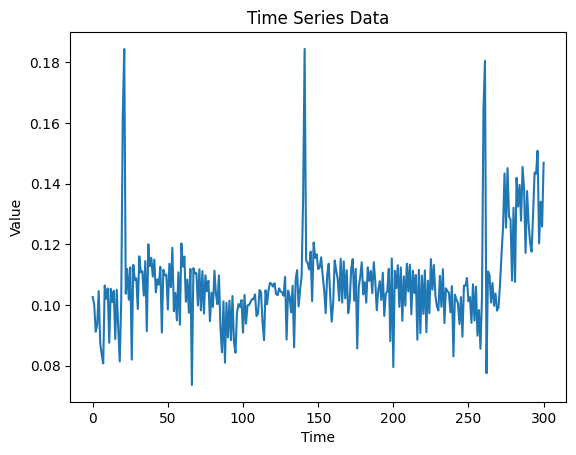

27
3685
defaultdict(<class 'list'>, {'opni-prometheus-node-exporter-d4tmr': ['process_cpu_seconds_total', 'node_scrape_collector_duration_seconds', 'container_cpu_usage_seconds_total', 'go_gc_duration_seconds_sum', 'scrape_duration_seconds', 'node_schedstat_running_seconds_total', 'instance:node_load1_per_cpu:ratio', 'go_memstats_gc_cpu_fraction', 'node_cpu_seconds_total', 'node_schedstat_waiting_seconds_total', 'node_pressure_cpu_waiting_seconds_total', 'node_netstat_Tcp_PassiveOpens', 'node_softnet_times_squeezed_total'], 'opni-kube-state-metrics-5df8ccf5-mkhfl': ['container_cpu_usage_seconds_total', 'scrape_duration_seconds'], 'opni-nats-1': ['container_cpu_usage_seconds_total'], 'prometheus-opni-prometheus-agent-0': ['container_cpu_usage_seconds_total', 'container_network_transmit_packets_total', 'container_cpu_system_seconds_total', 'container_cpu_user_seconds_total'], 'cortex-all-0': ['container_network_receive_packets_total', 'scrape_duration_seconds', 'log_messages_total', 'cor

In [200]:
def process_task2(d, q1 ,m_name, is_debug = False):
    count = 0
    total = 0
    for r in q1["result"]:
        if "pod" not in r["metric"]:
            # print(r)
            continue
        pod = r["metric"]["pod"]
        list0 = r["values"]
        values0 = [float(l[1]) for l in list0]
        history, evaluate_window, test_window = values0[:240], values0[-60:], values0[-10:]
        try:
            is_anomaly, p_value = ks_anomaly_detection(evaluate_window)
            total += 1
            if is_anomaly:
                mean = np.mean(history)
                std_dev = np.std(history)
                rule1 = max(test_window) > mean + 3 * std_dev or min(test_window) < mean - 3 * std_dev
                rule2 = max(test_window) > max(history) or min(test_window) < min(history)
                # _, rule3 = ks_anomaly_detection(values0, cut=290)
                if rule1 : # rule1 and rule2
                    # z_s = zscore_anomaly_detection(values0)
                    # z_s_binary = True if len(z_s) > 0 else False
                    # if z_s_binary:
                    count += 1
                    d[pod].append(m_name)
                    # if is_debug:
                    if True:
                        print(m_name)
                        print(pod)
                        plt_plot(np.array(values0))
                        print("=====================")
        except Exception as e:
            pass
    s2 = time.time()
    return count, total

d = defaultdict(list)
total_count = 0
total = 0
for i,q in enumerate(qs):
    c, t = process_task2(d,q, metrics[i])
    total_count += c
    total += t
print(total_count)
print(total)
print(d)